Анализ убытĸов приложения Procrastinate PRO+
=====================================================

Описание проекта:
Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:

- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Нам предстоит исследовать:

- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

# Содержание проекта
### **1. Приоритизация гипотез**  
### **2. Функции для расчета и анализа LTV, ROI, удержания и конверсии**  
### **3. Исследовательский анализ данных**  
### **4. Маркетинг**  
### **5. Оценка окупаемости рекламы для привлечения пользователей**  
### **6. Общие выводы**

### 1. Скачивание файлов с  данными и изучение информации

Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# считаем файлы 
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),
    pd.read_csv('/datasets/orders_info_short.csv'),
    pd.read_csv('/datasets/costs_info_short.csv')
)

In [3]:
def investigate(file):
    print(f'Колонок: {file.shape[1]}\nCтрок: {file.shape[0]}')
    print('-'*50)
    print('Типы данных столбцов:')
    print(file.dtypes)
    print('-'*50)
    print('Количество пропусков:', visits.isna().sum().sum())
    print('Количество дубликатов:', file.duplicated().sum())
    print('-'*50)

In [4]:
for file in visits, orders, costs:
    display(file.head())
    investigate(file)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


Колонок: 6
Cтрок: 309901
--------------------------------------------------
Типы данных столбцов:
User Id           int64
Region           object
Device           object
Channel          object
Session Start    object
Session End      object
dtype: object
--------------------------------------------------
Количество пропусков: 0
Количество дубликатов: 0
--------------------------------------------------


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Колонок: 3
Cтрок: 40212
--------------------------------------------------
Типы данных столбцов:
User Id       int64
Event Dt     object
Revenue     float64
dtype: object
--------------------------------------------------
Количество пропусков: 0
Количество дубликатов: 0
--------------------------------------------------


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Колонок: 3
Cтрок: 1800
--------------------------------------------------
Типы данных столбцов:
dt          object
Channel     object
costs      float64
dtype: object
--------------------------------------------------
Количество пропусков: 0
Количество дубликатов: 0
--------------------------------------------------


In [5]:
# Приведем названия столбцов к единому стилю
for data in visits, orders, costs:
    data.columns = data.columns.str.lower().str.replace(' ', '_')

In [6]:
# преобразование данных о времени
visits['session_start']= pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders['dt'] = pd.to_datetime(orders['event_dt']).dt.date
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

**Вывод:**

Данные загружены, пропусков и дубликатов нет. Преобразованы типы данных в столбцах со временными данными. Названия столбцов приведены к единому стилю.

### 2. Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [7]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, costs):

    # находим параметры первых посещений
    profiles = (visits.sort_values(by=['user_id', 'session_start'])
                .groupby('user_id')
                .agg({'session_start': 'first',
                      'channel': 'first',
                      'device': 'first',
                      'region': 'first'}
                    )
                .rename(columns={'session_start': 'first_ts'})
                .reset_index()
               )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (profiles.groupby(['dt', 'channel'])
                 .agg({'user_id': 'nunique'})
                 .rename(columns={'user_id': 'unique_users'})
                 .reset_index()
                )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']],
                              on=['dt', 'channel'],
                              how='left'
                             )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [8]:
# функция для расчёта удержания

def get_retention(profiles, visits, observation_date, horizon_days, dimensions=[], ignore_horizon=False,):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
   
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(visits[['user_id', 'session_start']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        
        cohort_sizes = (df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'}))
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [9]:
# функция для расчёта конверсии

def get_conversion(profiles, orders, observation_date, horizon_days, dimensions=[]):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
        
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (orders.sort_values(by=['user_id', 'event_dt'])
                       .groupby('user_id')
                       .agg({'event_dt': 'first'})
                       .reset_index()
                      )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (df.groupby(dims)
                        .agg({'user_id': 'nunique'})
                        .rename(columns={'user_id': 'cohort_size'})
                       )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
       
        # делим каждую «ячейку» в строке на размер когорты и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [10]:
# функция для расчёта LTV и ROI

def get_ltv(profiles, orders, observation_date, horizon_days, dimensions=[], ignore_horizon=False):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
        
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(orders[['user_id', 'event_dt', 'revenue']], on='user_id', how='left')
    
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(index=dims, columns='lifetime', values='revenue', aggfunc='sum')
        
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (df.groupby(dims)
                        .agg({'user_id': 'nunique'})
                        .rename(columns={'user_id': 'cohort_size'})
                       )
        
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
       
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (cac.groupby(dims)
               .agg({'acquisition_cost': 'mean'})
               .rename(columns={'acquisition_cost': 'cac'})
              )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [11]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df## Функция для расчёта LTV и ROI

In [12]:
# функция для визуализации удержания

def plot_retention(retention_raw, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention_raw.drop(columns=['cohort_size', 0])
    
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # если в индексах таблицы удержания только payer, добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name for name in retention_history.index.names if name not in ['dt', 'payer']
    ]
    
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания платящих пользователей на {}-й день'.format(horizon))

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon))
    
    plt.tight_layout()
    plt.show()## Функция для сглаживания фрейма

In [13]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [14]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### 3. Исследовательский анализ данных

**Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.**


In [15]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
display(profiles.head())

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [16]:
# определим минимальную и максимальную дату привлечения пользователей
# определите доступный интервал привлечения пользователей
print('Минимальная дата привлечения пользователей:', profiles['dt'].min())
print('Максимальная дата привлечения пользователей:', profiles['dt'].max())  

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


In [17]:
# Момент анализ установим из условия: данные смотрим 1-го ноября 2019 года
# Горизонт анализа установим из условия: окупаемость должна наступать
# не позднее, чем через 2 недели после привлечения пользователей

observation_date = datetime(2019, 11, 1).date() 
horizon_days = 14

In [18]:
# функция для расчета соотношения пользователей и покупателей
def users_payers(option):
    users = profiles[option].value_counts()
    payers = profiles.query('payer == True')[option].value_counts()
    df = pd.DataFrame({'users': users, 'payers': payers}).sort_values(by='users', ascending=False) 
    df['%, users'] = (df['users']/df['users'].sum()*100).round(2)
    df['%, payers'] = (df['payers']/df['payers'].sum()*100).round(2)
    df['%, conversion'] = (df['payers']/df['users']*100).round(2)
    users_sum = df['users'].sum()
    payers_sum = df['payers'].sum()
    share = (payers_sum/users_sum*100).round(2)
    
    print('Пользователей всего:',users_sum)
    print(f'Покупателей всего: {payers_sum}, ({share} %)')
    
    display(df.sort_values(by='%, conversion',ascending=False))
    df[['users','payers']].plot(kind='bar',rot=10,title = 'Количество пользователей и покупателей', figsize=(14, 8),grid=True)

**Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?**

Пользователей всего: 150008
Покупателей всего: 8881, (5.92 %)


,users,payers,"%, users","%, payers","%, conversion"
United States,100002,6902,66.66,77.72,6.90
Germany,14981,616,9.99,6.94,4.11
UK,17575,700,11.72,7.88,3.98
France,17450,663,11.63,7.47,3.80


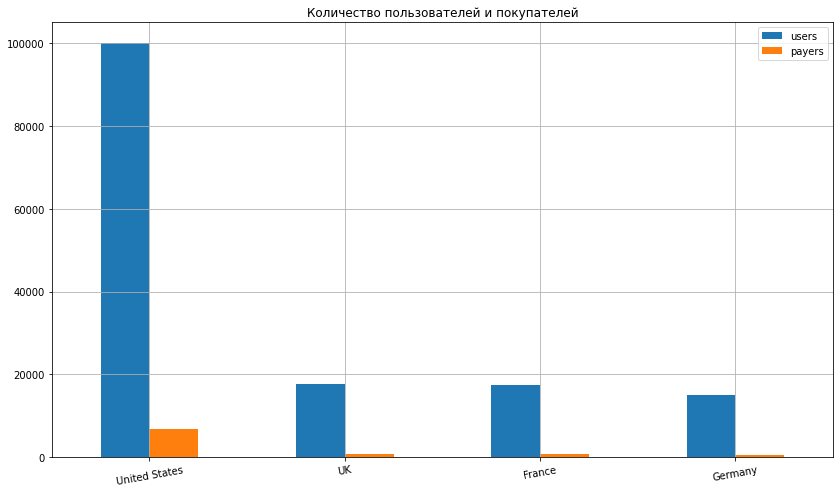

In [19]:
users_payers('region')

**Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?**


Пользователей всего: 150008
Покупателей всего: 8881, (5.92 %)


,users,payers,"%, users","%, payers","%, conversion"
Mac,30042,1912,20.03,21.53,6.36
iPhone,54479,3382,36.32,38.08,6.21
Android,35032,2050,23.35,23.08,5.85
PC,30455,1537,20.30,17.31,5.05


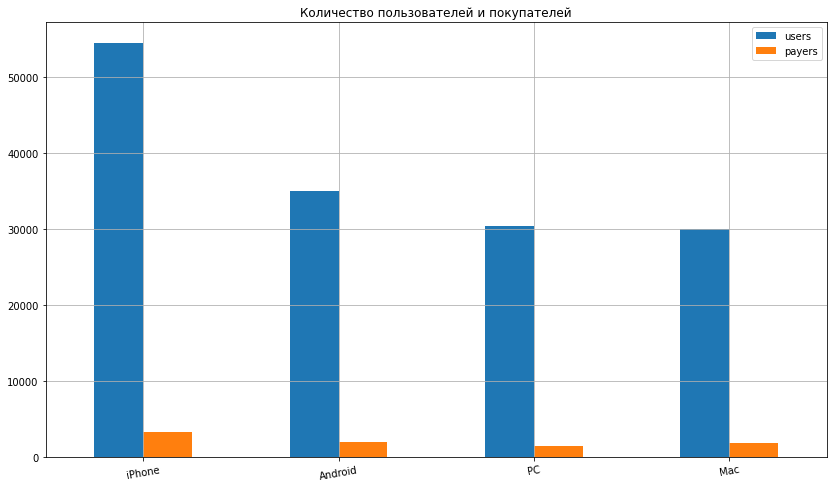

In [20]:
users_payers('device')


**По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?**


Пользователей всего: 150008
Покупателей всего: 8881, (5.92 %)


,users,payers,"%, users","%, payers","%, conversion"
FaceBoom,29144,3557,19.43,40.05,12.20
AdNonSense,3880,440,2.59,4.95,11.34
lambdaMediaAds,2149,225,1.43,2.53,10.47
TipTop,19561,1878,13.04,21.15,9.60
RocketSuperAds,4448,352,2.97,3.96,7.91
WahooNetBanner,8553,453,5.70,5.10,5.30
YRabbit,4312,165,2.87,1.86,3.83
MediaTornado,4364,156,2.91,1.76,3.57
LeapBob,8553,262,5.70,2.95,3.06
OppleCreativeMedia,8605,233,5.74,2.62,2.71


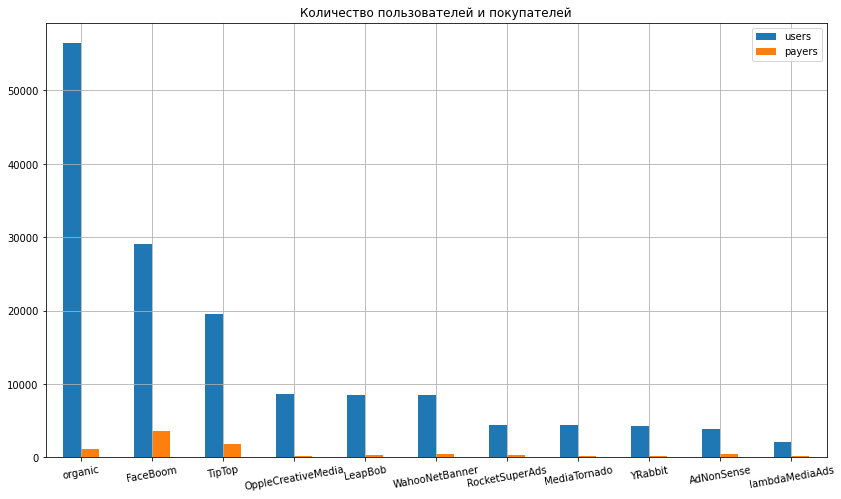

In [21]:
users_payers('channel')

**Вывод:**

Всего пользователей 150008, из которых покупателей 8881, конверсия в покупателей 5.9%. Эта конверсия общая - за весь изучаемый период.

- 67% пользователей приходят из США. Здесь же и самая высокая конверсия 6,9%,
- По используемым устройствам лидером является iPhone: 36,3% пользователей и конверсия 6,2%. При этом самая высокая конверсия у пользователей Mac - 6,36%,
- Всего источников пользователей 11 из них 38% приходят из канала organic с конверсией 2%, при этом максимальное количество покупателей приходит из канала FaceBoom - 40%, где конверсия составляет 12,2% - это максимальное значение.

### 4. Маркетинг


**Посчитаем общую сумму расходов на маркетинг.**


In [22]:
print('Общие затраты на маркетинг:', costs['costs'].sum().round())

Общие затраты на маркетинг: 105497.0


**Посчитаем затраты по источникам.**

In [23]:
channel_costs = costs.groupby('channel').agg({'costs':'sum'}).sort_values('costs',ascending=False)
channel_costs['%, costs'] = (channel_costs['costs']/channel_costs['costs'].sum()*100).round(2)
channel_costs

,costs,"%, costs"
channel,,
TipTop,54751.30,51.90
FaceBoom,32445.60,30.75
WahooNetBanner,5151.00,4.88
AdNonSense,3911.25,3.71
OppleCreativeMedia,2151.25,2.04
RocketSuperAds,1833.00,1.74
LeapBob,1797.60,1.70
lambdaMediaAds,1557.60,1.48
MediaTornado,954.48,0.90


**Построим визуализацию динамики изменения расходов во времени (по месяцам и неделям) по каждому источнику.**

Text(0.5, 1.0, 'Расходы по месяцам')

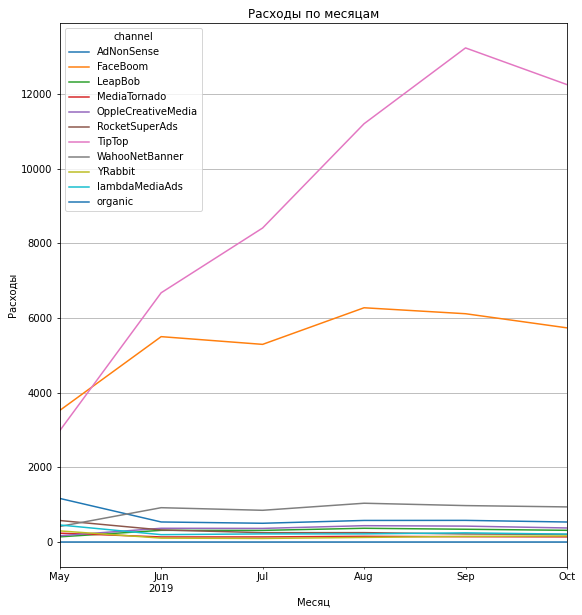

In [24]:
plt.figure(figsize=(20,10))
ax1=plt.subplot(1,2,1)
profiles.pivot_table(index='month',columns='channel', values = 'acquisition_cost', aggfunc = 'sum').plot(grid=True,ax=ax1)
plt.legend
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.title('Расходы по месяцам')


V2 Добавлена подпись. Расходы на TipTop - рекордсмен по росту от месяца к месяцу. На втором месте с явным отставанием - FaceBoom.

In [25]:
profiles['week'] = profiles['first_ts'].dt.isocalendar().week
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost,week
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172,19
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237,28
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000,40
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235,34
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769,40


Text(0.5, 1.0, 'Расходы по неделям')

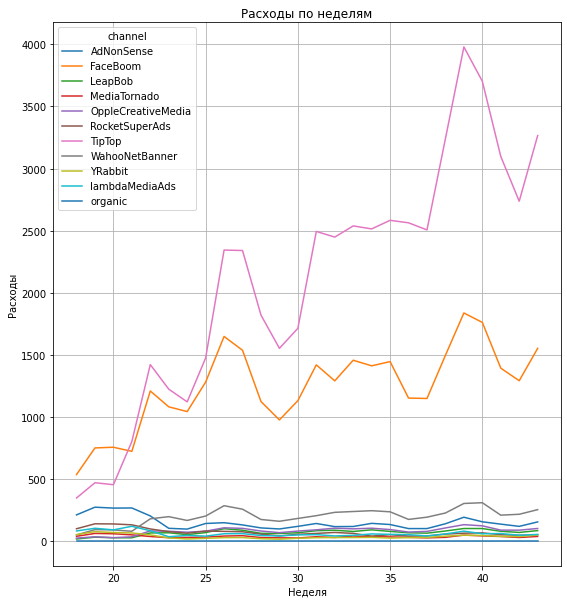

In [26]:
plt.figure(figsize=(20,10))
ax2=plt.subplot(1,2,1)
profiles.pivot_table(index='week',columns='channel', values = 'acquisition_cost', aggfunc = 'sum').plot(grid=True,ax=ax2)
plt.legend
plt.xlabel('Неделя')
plt.ylabel('Расходы')
plt.title('Расходы по неделям')

В основном рекламные расходы идут на два источника - FaceBoom и TipTop. До 38-й недели расходы на них имели общую тенденцию к росту.

**Сколько в среднем стоило привлечение одного покупателя из каждого источника?**

In [27]:
# сколько пришло пользователей из каждого источника
channel_users = profiles.groupby('channel')['user_id'].nunique()
# проверка количества пользователей
channel_users.sum()

150008

In [28]:
# исключим organic
channel_users = channel_users[channel_users.index != 'organic']

In [29]:
# сколько затратили за каждый источник
channel_costs = costs.groupby('channel')['costs'].sum()

In [30]:
# объединим количество пользователей и затраты по каналам
users_costs = pd.DataFrame({'users': channel_users, 'costs': channel_costs})

In [31]:
# цена привлечения одного пользователя
users_costs['price'] = (users_costs['costs']/users_costs['users'])
users_costs.sort_values(by='price', ascending=False)

,users,costs,price
channel,,,
TipTop,19561,54751.30,2.799003
FaceBoom,29144,32445.60,1.113286
AdNonSense,3880,3911.25,1.008054
lambdaMediaAds,2149,1557.60,0.724802
WahooNetBanner,8553,5151.00,0.602245
RocketSuperAds,4448,1833.00,0.412095
OppleCreativeMedia,8605,2151.25,0.250000
YRabbit,4312,944.22,0.218975
MediaTornado,4364,954.48,0.218717


**Вывод:**

Самые дорогие пользователи привлекаются из канала TipTop - 2.8 единиц за пользователя, на втором месте FaceBoom - 1.1 единиц за пользователя. Минимальные расходы - 0.2 единицы за пользователя из канала LeapBob

### 5. Оценка окупаемости рекламы для привлечения пользователей

**С помощью LTV и ROI:**

**Оценим общую окупаемость рекламы.**



In [32]:
# исключим из расчетов органических пользователей оставим только рекламных

adv_profiles = profiles.query('channel != "organic"')

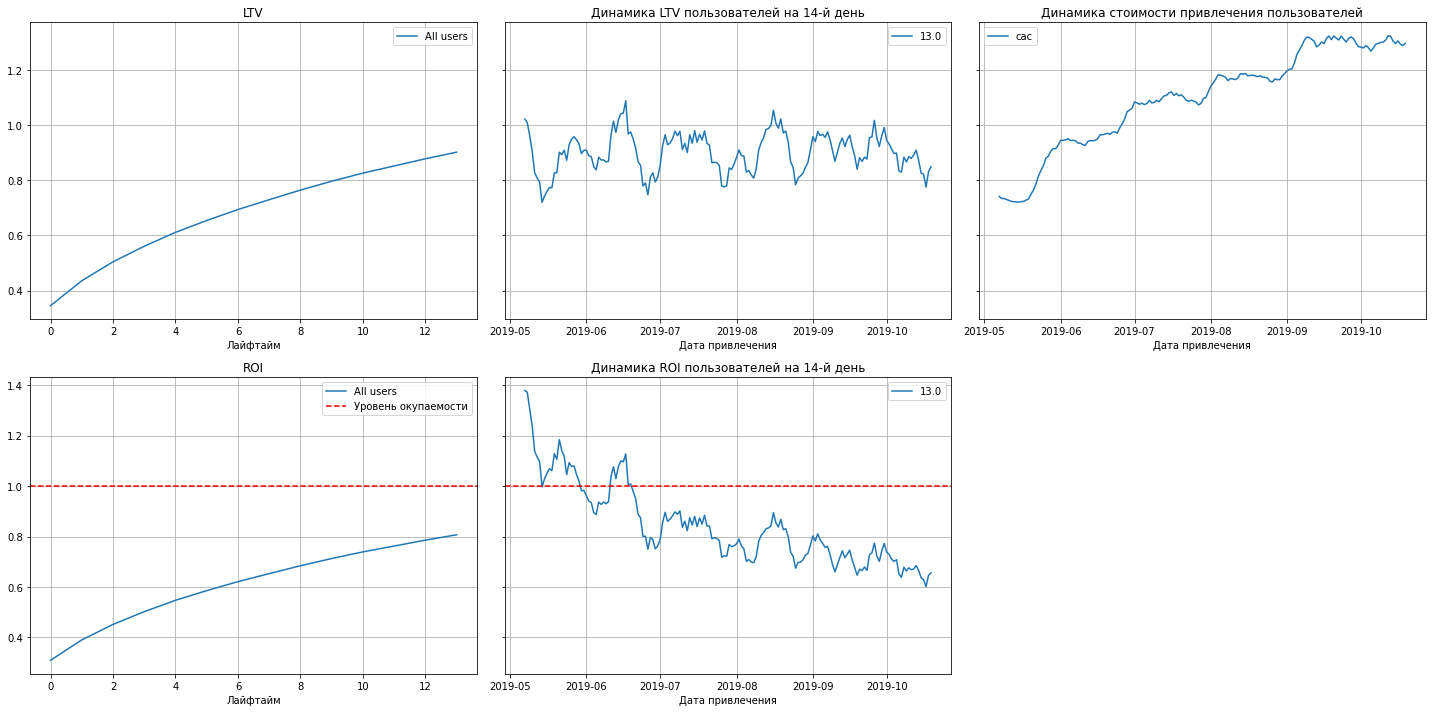

In [33]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    adv_profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Выводы**
- Реклама не окупается. Кривая ROI "не достает" до прямой уровня окупаемости.
- Стоимсть привлечения новых пользователей растет. Значит, увеличиваются затраты на рекламный бюджет.
- LTV стабилен. Значит "качество" пользователей примерно на одном уровне.
- Динамика ROI на 14-й день снижается.

Пользователи стабильно приносят деньги, но стоимость их привлечения растет, в результате окупаемость падает. Для того, чтобы разобраться нужны более детальные графики (разбивка по устройству, стране, источнику)

**Построим и изучим графики конверсии и удержания.**

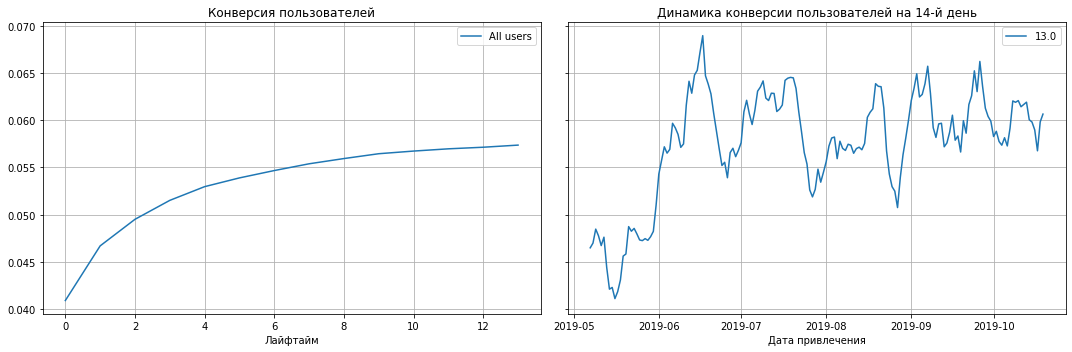

In [34]:
# построим график конверсии и динамику изменения
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Показатель конверсии растет. Динамика растет до определенного момента, затем остается на относительно стабильном уровне.

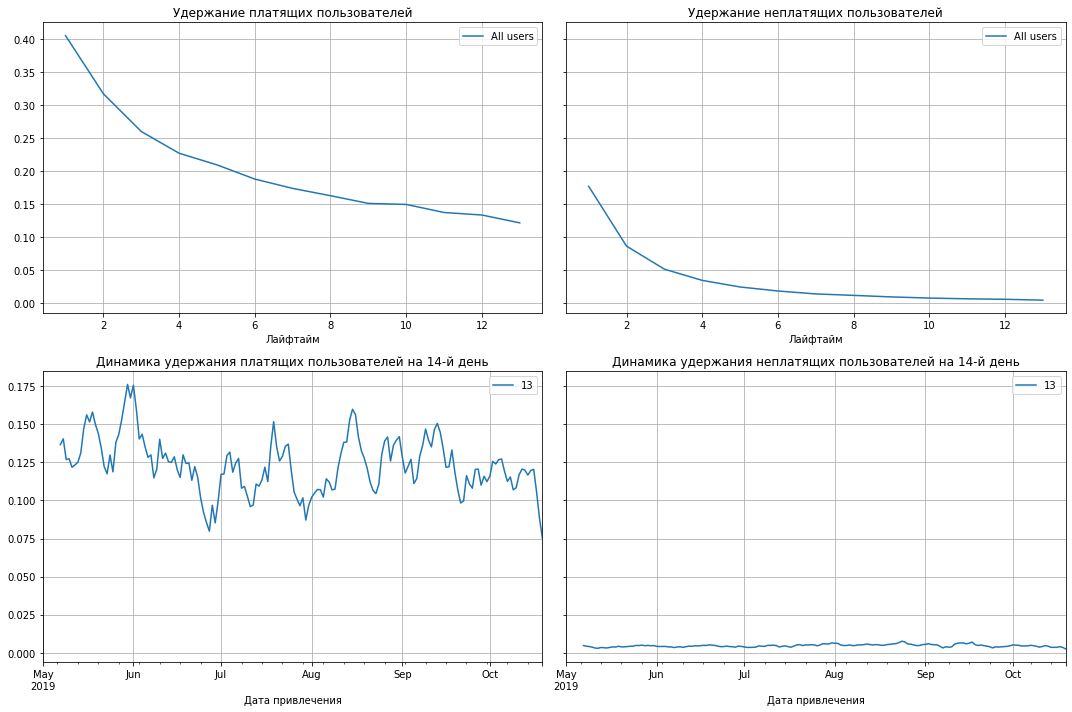

In [35]:
# построим график удержания и динамику изменения
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание платящих и неплатящих пользователей имеет тенденцию к падению. Платящие пользователи удерживаются лучше. Динамика платящих пользователей имеет некоторые колебания, но остается на стабильном уровне. Неплатящих пользователей - фактически константа.

**Окупаемость с разбивкой по странам**

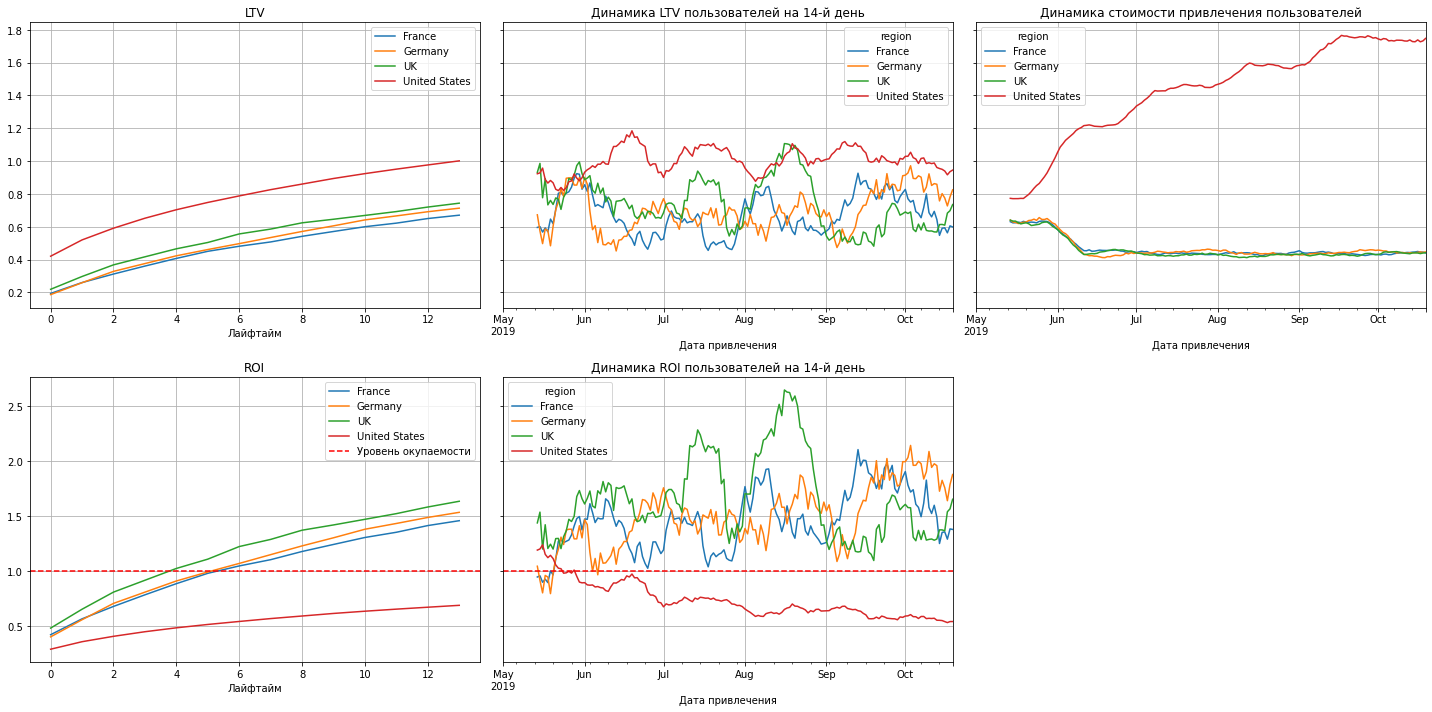

In [36]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    adv_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

**Из разбивки по странам можно сделать следующие выводы:**

- Больше всего клиентов приходит из США
Реклама:
- окупается во Франции, Германии и Британии,
- не окупается в США.
Стоимость привлечения:
- стабильна во Франции, Германии и Британиии и почти одинакова,
- резко растет в США.
- LTV подвержен изменениям, но более-менее стабилен,
Динамика ROI пользователей на 14-й день:
- стабильно выше окупаемости во Франции, Германии и Британиии
- падает ниже окупаемости в США.

**Вывод: Из разбивки по странам видно, что явная просадка по окупаемости в США.**

**Окупаемость с разбивкой по источникам привлечения**

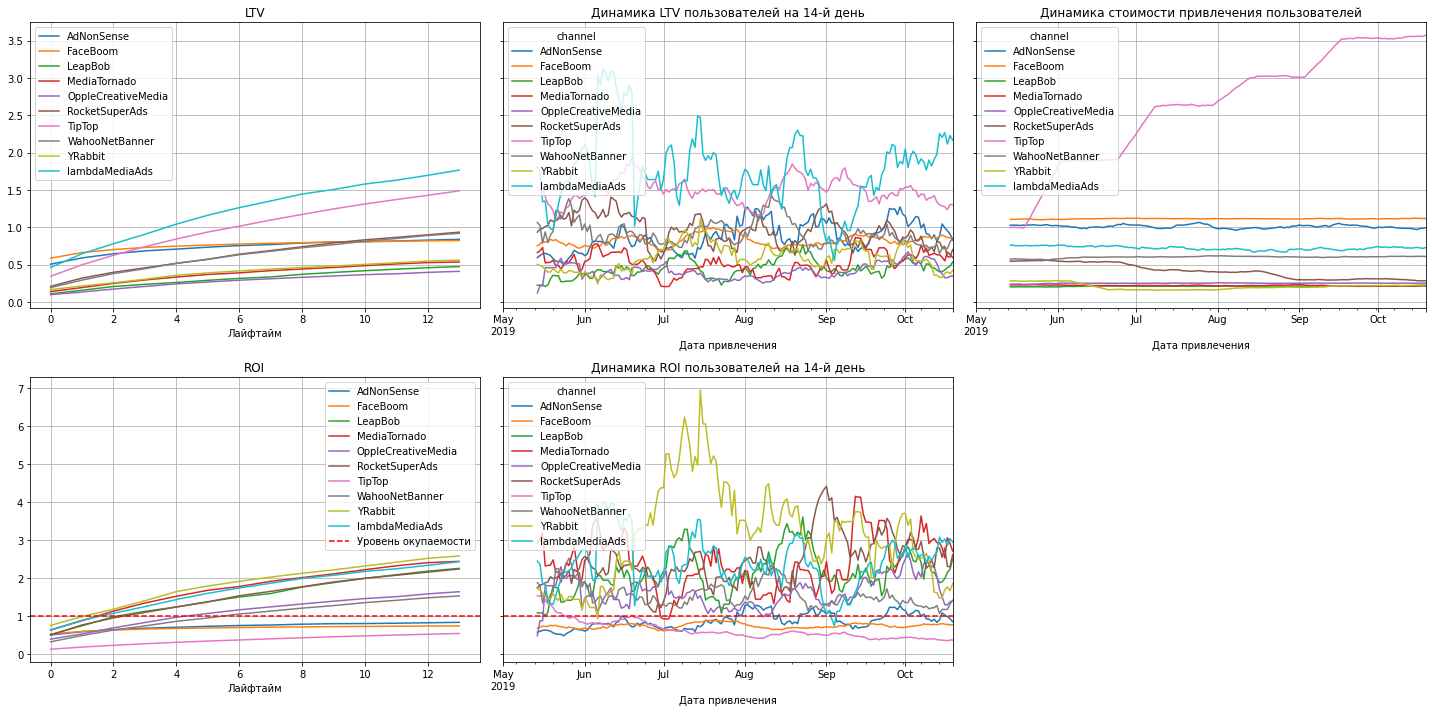

In [37]:


dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    adv_profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Из разбивки по источникам привлечения можно сделать основной выводы - резко растет стоимость привлечения из канала TipTop. ROI ниже уровня окупаемости: TipTop, FaceBoom, AdNonSense

**Смотрим окупаемость с разбивкой по устройствам**


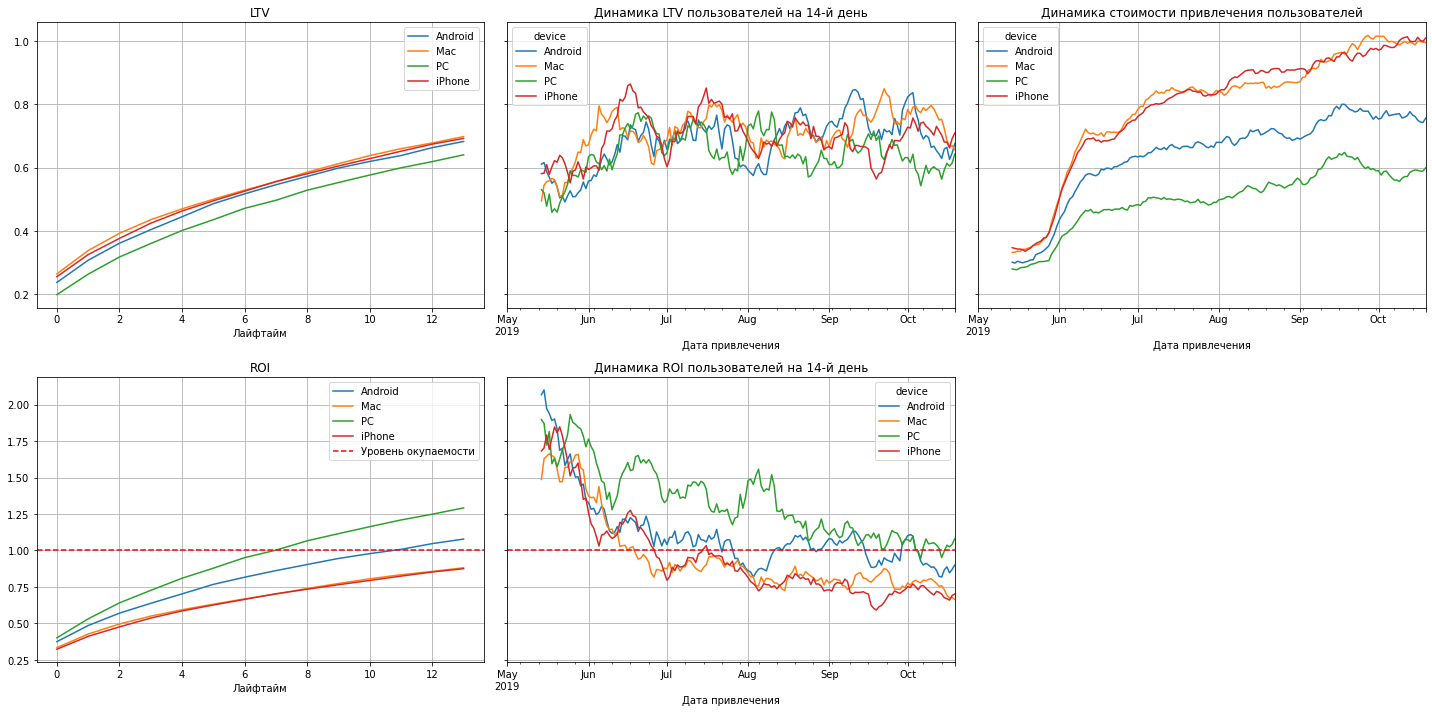

In [38]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

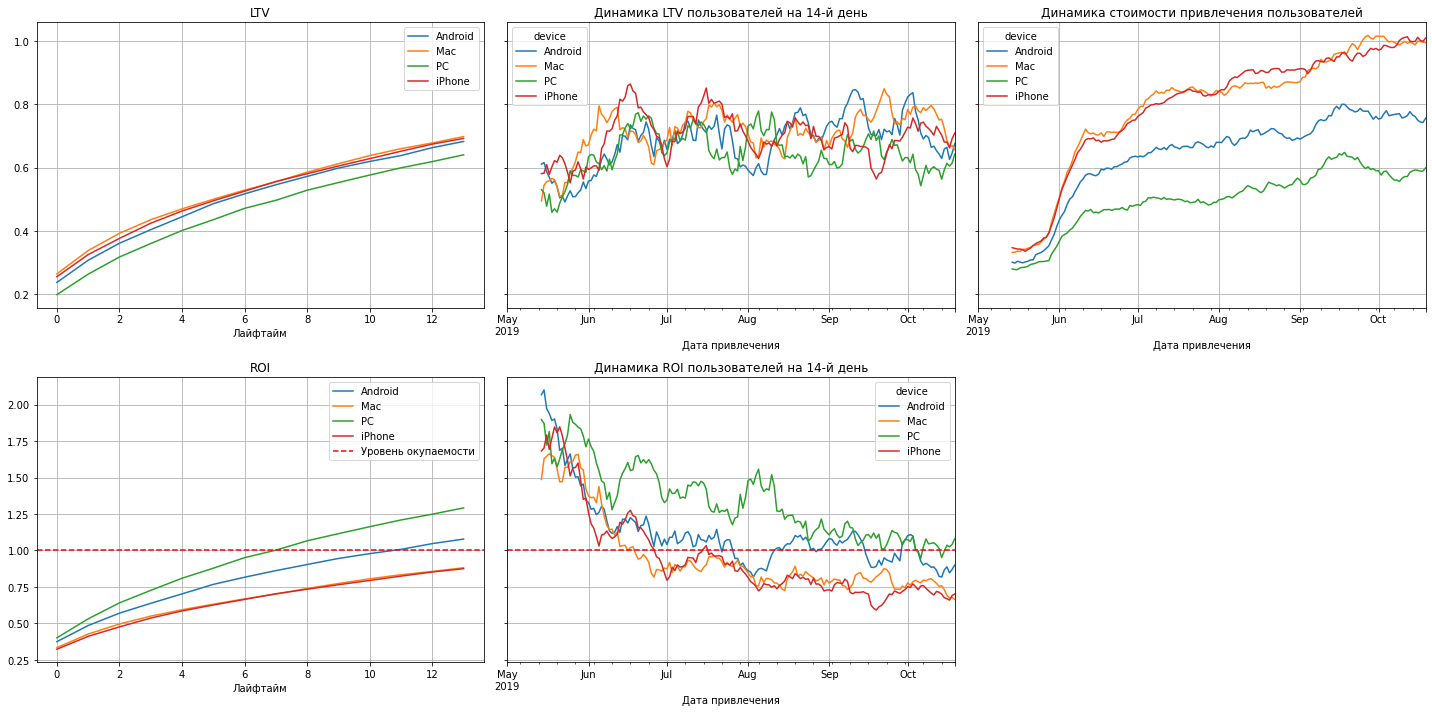

In [39]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)


Из разбивки по по устройствам видим, что пользователи PC и Android стабильно окупаются, а владельцы Mac и iPhone нет, что связано с более высокой динамикой стоимости привлечения пользователей

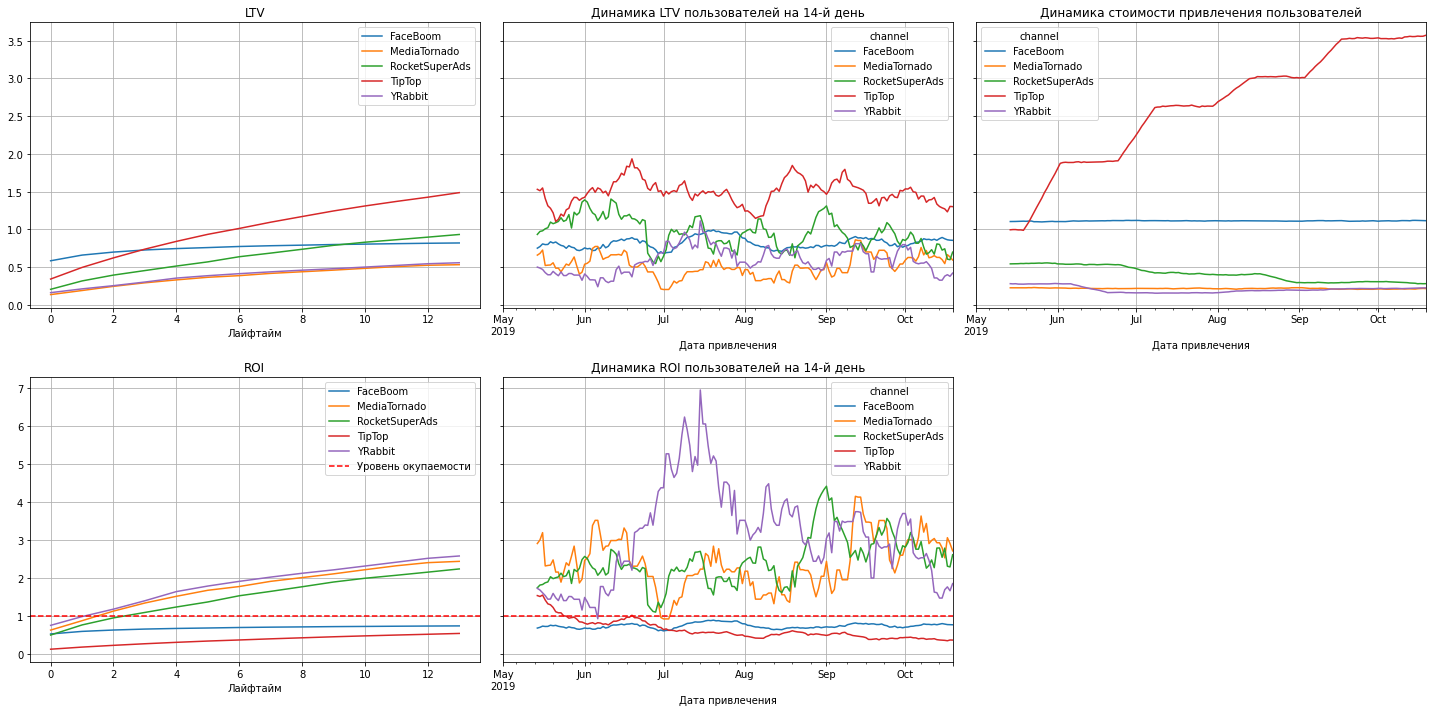

In [40]:
# проверим окупаемость для США
profiles_usa = adv_profiles.query('region == "United States"')

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Из графиков видим, что высокие расходы на привлечение в каналах FaceBoom и TipTop. При этом в канале TipTop динамика стоимости привлечения ещё и растет.

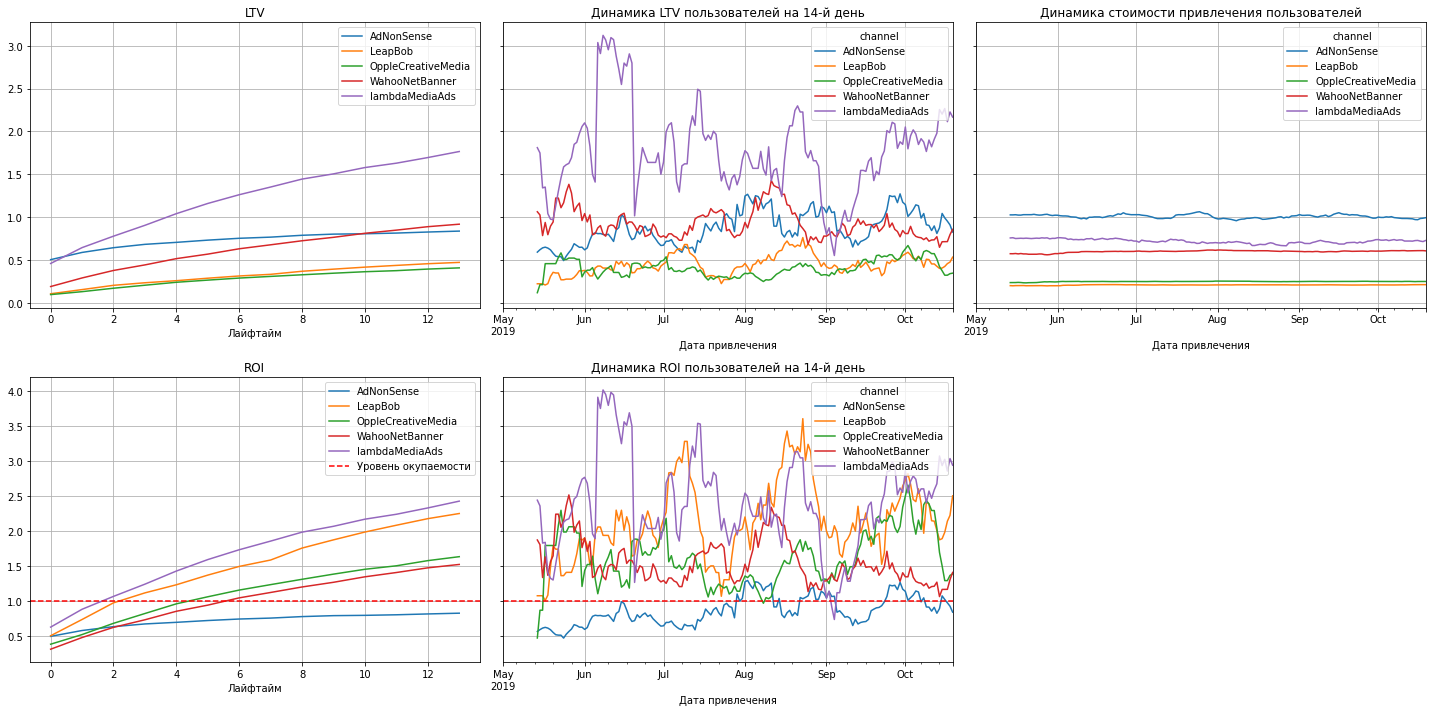

In [41]:
#проверим окупаемость для Европы
profiles_not_usa = adv_profiles.query('region != "United States"')

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_not_usa, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

В Европе стоимость привлечения пользователей в динамике стабильна. Больше каналов привлечения окупается.

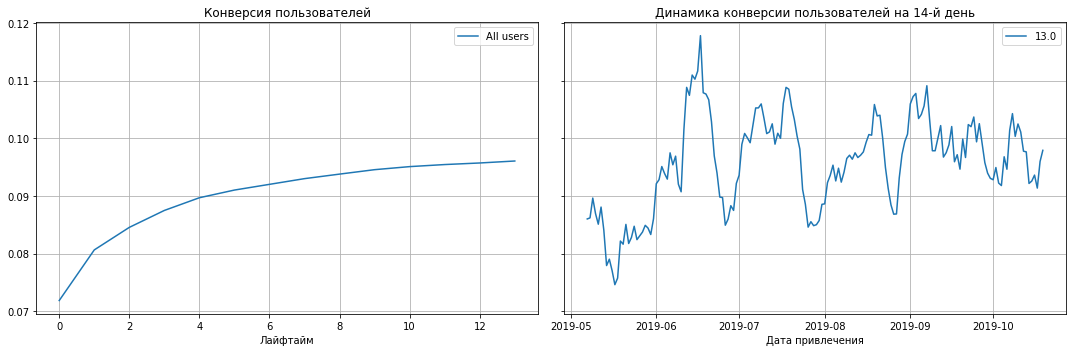

In [43]:
# построим график конверсии и динамику изменения для рынка США
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_usa, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

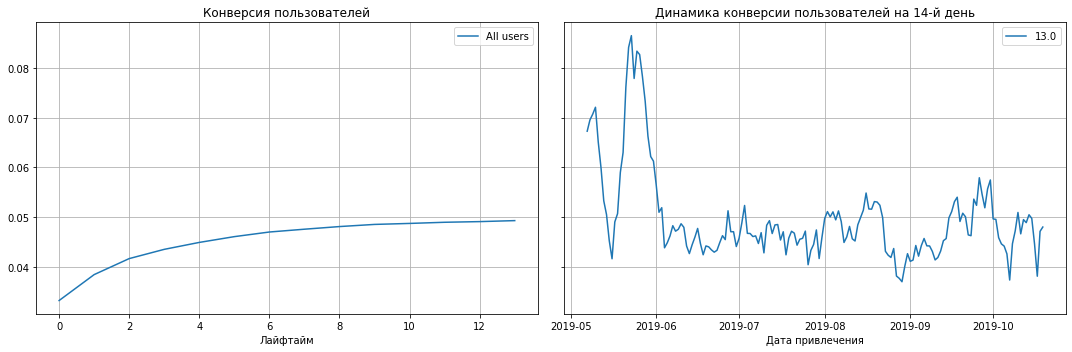

In [44]:
# построим график конверсии и динамику изменения для рынка Европы
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_not_usa, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия в США выше, динамика имеет большие колебания. Но тенденции в США и Европе схожи - стабильность. 

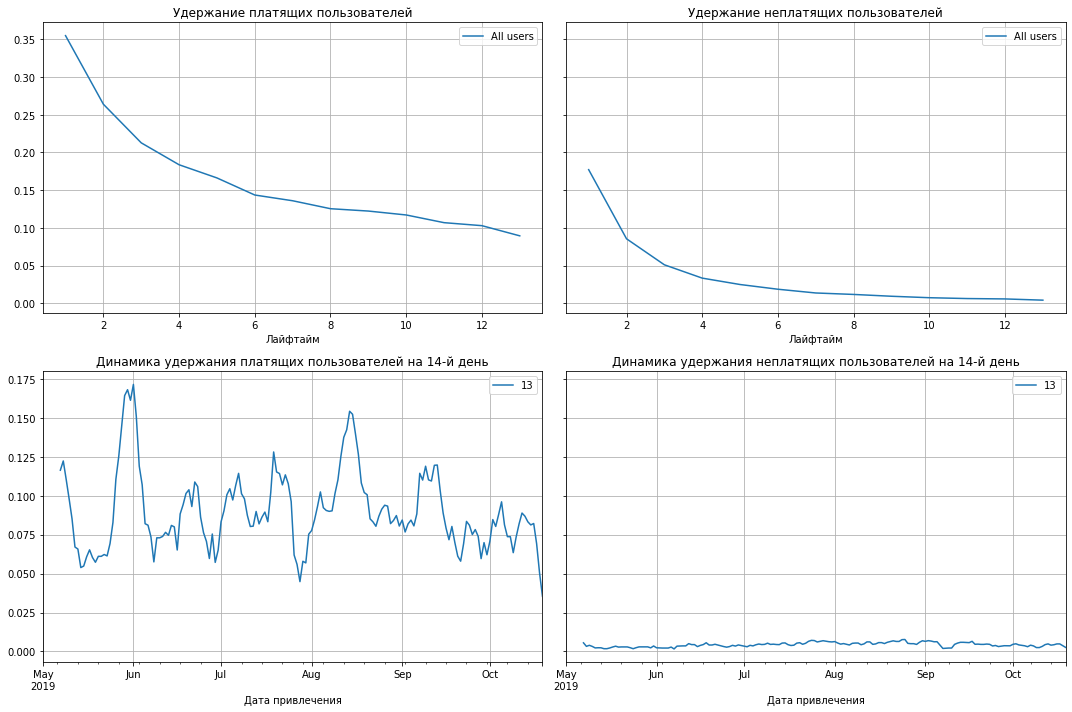

In [45]:
# построим график удержания и динамику изменения для США
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_usa, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

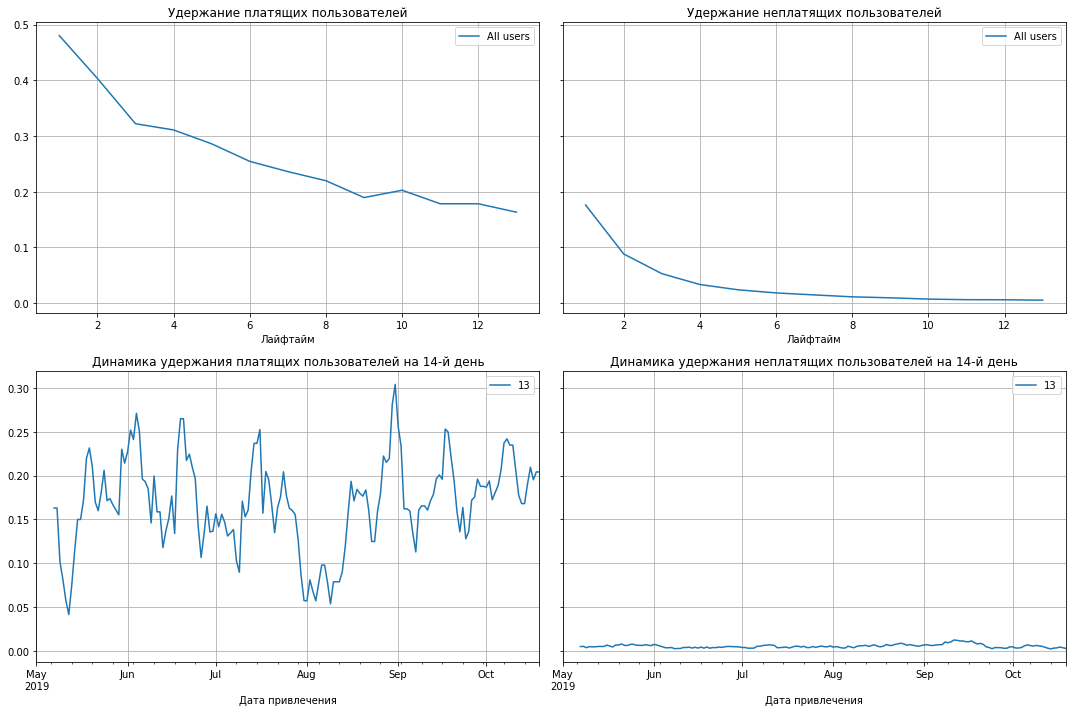

In [46]:
# построим график удержания и динамику изменения для Европы
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_not_usa, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание в Европе имеет более высокие значения. 

### 6. Общие выводы

Во время исследования мы выяснили, что всего зарегистрировано 150 008 пользователей 6% из которых сделали покупки.

Пользователи приходят из 4 стран. Больше всего пользователей приходит из США 67%, конверсия в покупатели составляет 6,9%. Из США приходит 77% покупателей.

По используемым устройствам на первом месте iphone: 36% пользователей и конверсия 6,2%, хотя самая высокая конверсия у пользователей Mac - 6,4%,

Максимальная выручка приходит из канала TipTop - 32,2%. Самый выгодный источник organic - 21,6% выучки и 42,2% прибыли.

Операционная прибыль составляет 110 466 ден.ед.

Рентабельность продаж: 51.0 %

Затраты на рекламу растут, продажи тоже растут и превышают затраты на рекламу.

Самые дорогие пользователи привлекаются из канала TipTop - 2.8 ден.ед. за одного пользователя, на втором месте FaceBoom - 1.1 ден.ед. за одного пользователя.

В процессе анализа бизнес-показателей мы выяснили, что причинами низкой окупаемости является:

высокая стоимость привлечения пользователей из каналов TipTop и FaceBoom,
рост цены привлечения TipTop,
низкое количество повторных покупок каналов FaceBoom и AdNonSense(как результат их убыточность).
Окупаемость с разбивкой по устройствам на результаты особо не влияет.

Отделу маркетинга необходимо:

разобраться с растущей динамикой привлечения пользователей TipTop, пока он прибылен но это может поменяться,
изучить как повлиять на привлечение organic пользователей, на них приходится 42% прибыли при минимальной конверсии,
больше вкладывать в канал WahooNetBanner, тк он на первом месте по прибыли из рекламных каналов,
изучить вопрос с повторными покупками в FaceBoom он приносит 40% продаж, у него максимальная конверсия в покупателей 12,2% и он убыточен,
аналогично разобраться с повторными покупками в AdNonSense.